In [35]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
!pip install tensorflow==2.12
import tensorflow as tf
import unicodedata

from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
!wget https://raw.githubusercontent.com/divar167/data/refs/heads/main/train.txt

--2025-02-03 19:38:23--  https://raw.githubusercontent.com/divar167/data/refs/heads/main/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99802 (97K) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>]  97.46K  --.-KB/s    in 0.01s   

2025-02-03 19:38:23 (7.15 MB/s) - ‘train.txt.1’ saved [99802/99802]



In [37]:
with open('train.txt') as file:
  data = [line.rstrip() for line in file]

In [38]:
from sklearn.model_selection import train_test_split


SEPARATOR = '<sep>'
train_filtered = [pair for pair in data if '<sep>' in pair and pair.strip() != '']

train_val, test = train_test_split(train_filtered, test_size=0.1, random_state=42)

train, val = train_test_split(train_val, test_size=0.1111, random_state=42)

train_input, train_target = map(list, zip(*[pair.split('<sep>') for pair in train_filtered]))

In [39]:
# Unicode normalization


def normalize_unicode(s):
    normalized = unicodedata.normalize('NFD', s)
    return ''.join(filter(lambda c: unicodedata.category(c) != 'Mn', normalized))

In [40]:
def preprocess_sentence(s):
  s = s.lower()
  s = normalize_unicode(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [41]:
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

In [42]:
def tag_target_sentences(sentences):
    tagged_sentences = ['<sos> ' + s + ' <eos>' for s in sentences]
    return tagged_sentences


In [43]:
train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [44]:
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 1087,
 'word_counts': '{"baga": 27, "vazraka": 115, "auramazda": 162, "hya": 204, "martiyam": 28, "ada": 112, "asmanam": 55, "imam": 67, "bumim": 21, "siyatim": 81, "martiyahya": 34, "artaxsacam": 5, "aivam": 25, "xsayathiyam": 29, "parunam": 19, "akunaus": 72, "framataram": 14, "adam": 166, "artaxsaca": 34, "xsayathiya": 253, "ahyaya": 61, "bumiya": 30, "duraiy": 12, "apiy": 16, "xsayathiyanam": 29, "paruzananam": 5, "dahyunam": 36, "vazrakaya": 20, "xsayarsahya": 13, "puca": 118, "darayavahaus": 22, "napa": 9, "haxamanisiya": 66, "xsayathiyahya": 17, "thatiy": 109, "vasna": 75, "auramazdaha": 56, "ima": 64, "hadis": 44, "xsayarsa": 35, "mana": 56, "pita": 33, "frataram": 7, "pasava": 38, "akunavam": 54, "mam": 62, "patuv": 34, "hada": 17, "bagaibis": 15, "utamaiy": 11, "xsacam": 37, "uta": 120, "tya": 126, "maiy": 50, "kartam

In [45]:
source_vocab_size = len(source_tokenizer.word_index) + 1

In [46]:
# Tokenizer for the English target sentences.
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')

target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_vocab_size = len(target_tokenizer.word_index) + 1
target_tokenizer.get_config()



{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 1087,
 'word_counts': '{"<sos>": 1087, "a": 65, "great": 138, "god": 29, "is": 76, "ahuramazda": 242, "who": 170, "created": 102, "man": 59, "<eos>": 1087, "heaven": 9, "this": 217, "earth": 64, "was": 94, "by": 106, "the": 676, "gave": 48, "happiness": 77, "to": 85, "made": 73, "artaxerxes": 43, "one": 32, "king": 498, "for": 49, "many": 35, "leader": 8, "all": 75, "i": 247, "am": 115, "of": 459, "land": 25, "wide": 20, "kings": 66, "nations": 34, "lands": 27, "xerxes": 61, "son": 125, "darius": 189, "achaemenids": 3, "grandson": 7, "achaemenid": 59, "says": 113, "grace": 71, "my": 78, "father": 32, "built": 63, "palace": 54, "after": 5, "that": 76, "may": 41, "with": 25, "gods": 31, "preserve": 2, "me": 122, "kingdom": 41, "and": 164, "what": 32, "have": 8, "protect": 36, "mine": 4, "world": 9, "hystaspes": 54, "mankind": 17,

In [47]:
#vectorize the input and target sentences
#each sentences turns into number vector
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [48]:
def generate_decoder_inputs_targets(sentences, tokenizer):
    seqs = tokenizer.texts_to_sequences(sentences)

    decoder_inputs = list(map(lambda s: s[:-1], seqs))  # Drop <eos>
    decoder_targets = list(map(lambda s: s[1:], seqs))  # Drop <sos>

    return decoder_inputs, decoder_targets


In [49]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target,
                                                                              target_tokenizer)
#train_decoder_inputs -> gave to decoder as next expected token
#train_decoder_targets ->  calculate the loss

In [50]:
max_encoding_len = len(max(train_encoder_inputs, key=len))

In [51]:
max_decoding_len = len(max(train_decoder_inputs, key=len))

In [52]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [53]:
def process_dataset(dataset):

  input, output = map(list, zip(*[pair.split('<sep>') for pair in dataset]))

  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [54]:
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val)

In [55]:
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test)

In [56]:
embedding_dim = 32
hidden_dim = 64
default_dropout = 0.3

epochs =220
batch_size = 16


In [57]:
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

encoder_embeddings = layers.Embedding(source_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

# Passing the input layer output to the embedding layer
encoder_embedding_output = encoder_embeddings(encoder_inputs)


encoder_lstm = layers.LSTM(hidden_dim,
                           return_state=True,
                           dropout=default_dropout,
                           name='encoder_lstm')

_ , state_h, state_c = encoder_lstm(encoder_embedding_output)

# (state_h, state_c) are initial states for the decoder.
encoder_states = (state_h, state_c)

In [58]:
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')


decoder_embeddings = layers.Embedding(target_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='decoder_embeddings')


decoder_embedding_output = decoder_embeddings(decoder_inputs)

decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')



#Since return_sequences is set to True, decoder_outputs is going to be a collection of
# the decoder's hidden state at each timestep.
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

# create a probability distribution
decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

y_proba = decoder_dense(decoder_outputs)


In [59]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics=['sparse_categorical_accuracy'])

We can visualize our model to get a better idea of the flow we've built.

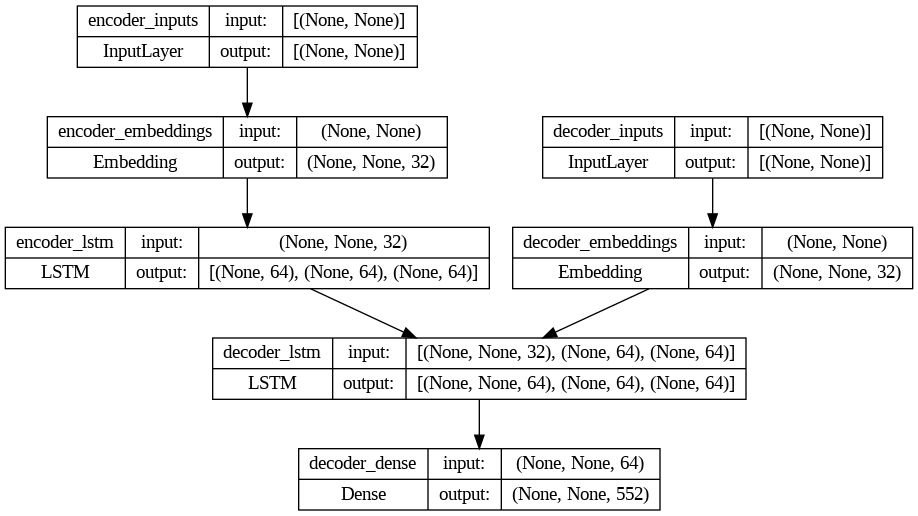

In [60]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [61]:


es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                    )

Epoch 1/220
68/68 [==============================] - 18s 107ms/step - loss: 5.4886 - sparse_categorical_accuracy: 0.1156 - val_loss: 4.5912 - val_sparse_categorical_accuracy: 0.1259
Epoch 2/220
68/68 [==============================] - 4s 53ms/step - loss: 4.5734 - sparse_categorical_accuracy: 0.1518 - val_loss: 4.4637 - val_sparse_categorical_accuracy: 0.1610
Epoch 3/220
68/68 [==============================] - 4s 54ms/step - loss: 4.4735 - sparse_categorical_accuracy: 0.1625 - val_loss: 4.3738 - val_sparse_categorical_accuracy: 0.1631
Epoch 4/220
68/68 [==============================] - 5s 71ms/step - loss: 4.3832 - sparse_categorical_accuracy: 0.1683 - val_loss: 4.2784 - val_sparse_categorical_accuracy: 0.1651
Epoch 5/220
68/68 [==============================] - 4s 55ms/step - loss: 4.2903 - sparse_categorical_accuracy: 0.1772 - val_loss: 4.1851 - val_sparse_categorical_accuracy: 0.1672
Epoch 6/220
68/68 [==============================] - 4s 52ms/step - loss: 4.2118 - sparse_categori

In [62]:
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

4/4 [==============================] - 0s 22ms/step - loss: 0.2619 - sparse_categorical_accuracy: 0.9380


[0.26190948486328125, 0.9380081295967102]

In [63]:
encoder_inputs = model.get_layer('encoder_inputs').input

encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]

#encoder_states is the expected output.
encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

Creating the decoder is similar. The major difference here is that there are two additional inputs to the decoder representing its LSTM hidden state (*decoder_input_state_h*) and cell state (*decoder_input_state_c*), respectively.
<br><br>
They are there because the encoder and decoder are now separate models, so we'll manually take the encoder's output (its final states) and use them as the decoder's initial state. From there, at each time step, we'll take the decoder's state outputs and feed them to the next time step.
<br><br>
The stand-alone decoder now takes as input:
- Either the '\<sos\>' token (at the beginning) or the output from the previous timestep. Either way, it'll now take only one token at a time.
- Hidden and cell states, either from the encoder initially or from the decoder's last time step.
<br>

And it outputs a probability distribution for the current output, and new hidden and cell states.

In [64]:
decoder_inputs = model.get_layer('decoder_inputs').input

decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# Inputs to represent the decoder's LSTM hidden and cell states. We'll populate
# these manually using the encoder's output for the initial state.
decoder_input_state_h = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_h')
decoder_input_state_c = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')


decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
)

#decoder_sequence_outputs = خروجی‌های احتمالاتی دیکودر
decoder_output_states = [decoder_output_state_h, decoder_output_state_c] #next input

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

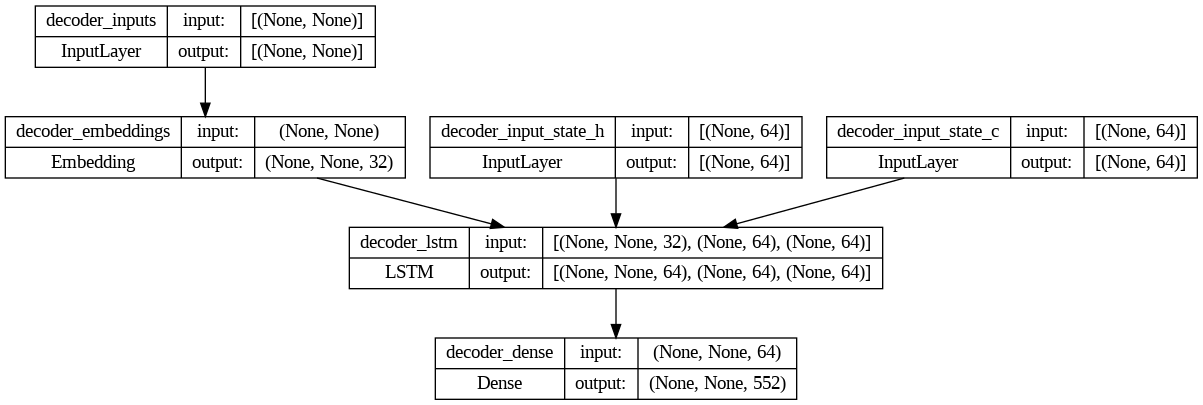

In [65]:
plot_model(decoder_model_no_attention, to_file='decoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

In [66]:
def translate_without_attention(sentence: str,
                                source_tokenizer, encoder,
                                target_tokenizer, decoder
                               ):

  max_translated_len = 30
  input_seq = source_tokenizer.texts_to_sequences([sentence])

  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq)

  start_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < max_translated_len:


    target_seq = np.zeros((1,1)) #single word
    target_seq[0, 0] = target_tokenizer.word_index[start_word] # Stores this index

    # Determine the next word
    target_y_proba, h, c = decoder.predict([target_seq] + states)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    start_word = target_tokenizer.index_word[target_token_index]

    if (start_word == '<eos>'):
      break

    decoded_sentence.append(start_word)
    states = [h, c]

  return tokenized_sentence[0], ' '.join(decoded_sentence)


In [67]:
from transformers import MT5ForConditionalGeneration, MT5Tokenizer

model_size = "large"
model_name = f"persiannlp/mt5-{model_size}-parsinlu-translation_en_fa"
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)


def run_model(input_string, **generator_args):
    input_ids = tokenizer.encode(input_string, return_tensors="pt")
    res = model.generate(input_ids, **generator_args)
    output = tokenizer.batch_decode(res, skip_special_tokens=True)
    return output




To test it out, we'll sample a bunch of sentences from the *test* dataset and translate them.

In [68]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': [], 'Persian_Reference' : []}

  for s in sentences:
    source, target = s.split('<sep>')
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Persian_Reference'].append(run_model(target)[0])
    translations['Translation'].append(run_model(translated)[0])

  return translations

We'll load the results into a Pandas **DataFrame** for easier viewing.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [69]:
pd.set_option('display.max_colwidth', None)  # No truncation of column content
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.max_rows', None)   # Display all columns

translations_no_attention = pd.DataFrame(translate_sentences(test, translate_without_attention,
                                                             source_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))


translations_no_attention

1/1 [==============================] - 0s 18ms/step


,Tokenized Original,Reference,Translation,Persian_Reference
0,mam auramazda patuv hada bagaibish,May Ahuramazda with the gods protect me,امیدوارم خورشید با خدایان از من محافظت کند,امیدوارم خورشید با خدایان از من محافظت کند
1,xsayarsahya darayavahausahya xshya puca,Xerxes the son of King Darius,خشايار شاه پسر شاه داریوس,خشايار شاه داریوس پسر خشايار شاه داروین
2,adam xsayarsa xsayathiya vazraka,I am Xerxes the great king,من خشايار شاه بزرگ هستم,من خشايار شاه بزرگم
3,adam auramazda vazraka vasna darayavaus,"I am Ahuramazda the great, by the grace of Darius",من داریوس هستم ، بزرگ ، من ساختم,من هرهمازاد بزرگ هستم، به لطف داریوس
4,tya patiy kartam vainataiy naibam,What against has been built and seems beautiful,خواست من مخالف چه چیزی است؟,آنچه در مقابل ساخته شده و زیبا به نظر می رسد
5,thatiy artaxsaca xsayathiya mam auramazda uta mithra baga patuv,King Artaxerxes says May Ahuramazda and the god Mithra protect me,شاه آرتاکزرکس می گوید: رحمت خداوند بر من باد.,شاه آرتاکزرکس می گوید: امیدوارم خورشید رحمت و خدای
6,ahyaya xsayathiya tya uba niyaka,this king that was grandfather,این پادشاه که پدربزرگ بود,این پادشاه که پدربزرگ بود
7,ada hya avam asmanam,who created yonder sky,چه کسی آسمان را خلق کرده است,چه کسی آسمان را خلق کرده است
8,vahaus xsayathiyahya puca haxamanisiya,the Achaemenid,ماده ضد کرم,آچامینید
9,mana siyatim abaraha,they brought me happiness,آن ها برای من خوشحالی آوردند,آن ها برای من خوشحالی آوردند


In [70]:
from nltk.translate.bleu_score import corpus_bleu

hypotheses = [hypothesis.lower().split() for hypothesis in translations_no_attention['Translation']]
references = [[reference.lower().split()] for reference in translations_no_attention['Persian_Reference']]

corpus_bleu_score = corpus_bleu(references, hypotheses)
print("Corpus BLEU Score:", corpus_bleu_score)


Corpus BLEU Score: 0.5010812197969133


In [72]:
import nltk

from nltk.translate.meteor_score import meteor_score
import numpy as np

import nltk
nltk.download('wordnet')

def corpus_meteor(expected, predicted):
    meteor_score_sentences_list = []
    for expect, predict in zip(expected, predicted):
        meteor_score_sentences_list.append(meteor_score([expect], predict))

    meteor_score_res = np.mean(meteor_score_sentences_list)
    return meteor_score_res

references = [reference.lower().split() for reference in translations_no_attention['Persian_Reference']]
hypotheses = [hypothesis.lower().split() for hypothesis in translations_no_attention['Translation']]

print(corpus_meteor(references, hypotheses))


[nltk_data] Downloading package wordnet to /root/nltk_data...


0.6313321081472655
